In [23]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v0_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

In [5]:
counts = df.groupby("CANCER_TYPE").agg({"CANCER_TYPE":"count"})
to_keep = counts[counts["CANCER_TYPE"] > 4500]
df = df[df.CANCER_TYPE.isin(to_keep.index)]

In [6]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [7]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Non-Small Cell Lung Cancer' 'Pancreatic Cancer' 'Melanoma'
 'Breast Cancer' 'Colorectal Cancer' 'Ovarian Cancer'] 7


In [8]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(data, classes)
m = SelectFromModel(clf, prefit=True)
data_new = m.transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [10]:
x_train, x_test, y_train, y_test = train_test_split(
									data_new, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(52060,)
(52060, 258)
(13015,)
(13015, 258)


In [11]:
learning_rate = 0.01
opt = 'ADAM'
lambda_l1 = 0.001
size_batch = 256
nb_epochs = 150

In [12]:
#12th try: feature selection + dropout + l2 regularizers + 7 cancer types only

model = Sequential()	
	
model.add(	
	Dense(256, input_dim = x_train.shape[1], activation = 'relu'))

model.add(	
	Dense(64, activation = 'relu',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               66304     
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 83,207
Trainable params: 83,207
Non-trainable params: 0
_________________________________________________________________


In [14]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [15]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [16]:
print(class_weights_d)

{0: 0.6995713345069003, 1: 0.7817873286179814, 2: 1.236638320110219, 3: 1.883774786510349, 4: 0.5183039136624752, 5: 2.0420491095944144, 6: 1.8766446775530803}


In [17]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/150
204/204 [==============================] - 2s 8ms/step - loss: 9.2620 - accuracy: 0.5097 - val_loss: 2.3076 - val_accuracy: 0.4641
Epoch 2/150
204/204 [==============================] - 1s 7ms/step - loss: 2.0535 - accuracy: 0.2536 - val_loss: 1.9719 - val_accuracy: 0.1510
Epoch 3/150
204/204 [==============================] - 1s 6ms/step - loss: 1.9500 - accuracy: 0.1456 - val_loss: 1.9567 - val_accuracy: 0.1291
Epoch 4/150
204/204 [==============================] - 1s 7ms/step - loss: 1.9406 - accuracy: 0.1368 - val_loss: 1.9533 - val_accuracy: 0.1302
Epoch 5/150
204/204 [==============================] - 1s 7ms/step - loss: 1.9181 - accuracy: 0.1662 - val_loss: 1.9390 - val_accuracy: 0.1680
Epoch 6/150
204/204 [==============================] - 1s 7ms/step - loss: 1.8573 - accuracy: 0.2280 - val_loss: 1.8800 - val_accuracy: 0.2637
Epoch 7/150
204/204 [==============================] - 1s 7ms/step - loss: 1.8031 - accuracy: 0.2676 - val_loss: 1.8312 - val_accuracy: 0.2892

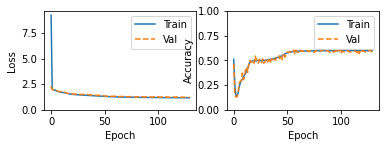

In [18]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()



In [33]:
score = model.evaluate(
	x_test, y_test, 
	batch_size = size_batch, verbose = 1)

print("Scores on test set: loss=%s accuracy=%s" % tuple(score))

51/51 [==============================] - 0s 3ms/step - loss: 1.2228 - accuracy: 0.5820
Scores on test set: loss=1.2227808237075806 accuracy=0.5820207595825195


In [48]:
y_pred = model.predict(x_test)
pred = []
for i in range(len(y_pred)):
  pred.append(list(y_pred[i]).index(max(y_pred[i])))

In [50]:
c_m = confusion_matrix(y_test, pred)

Text(0.5, 1.0, 'Confusion Matrix')

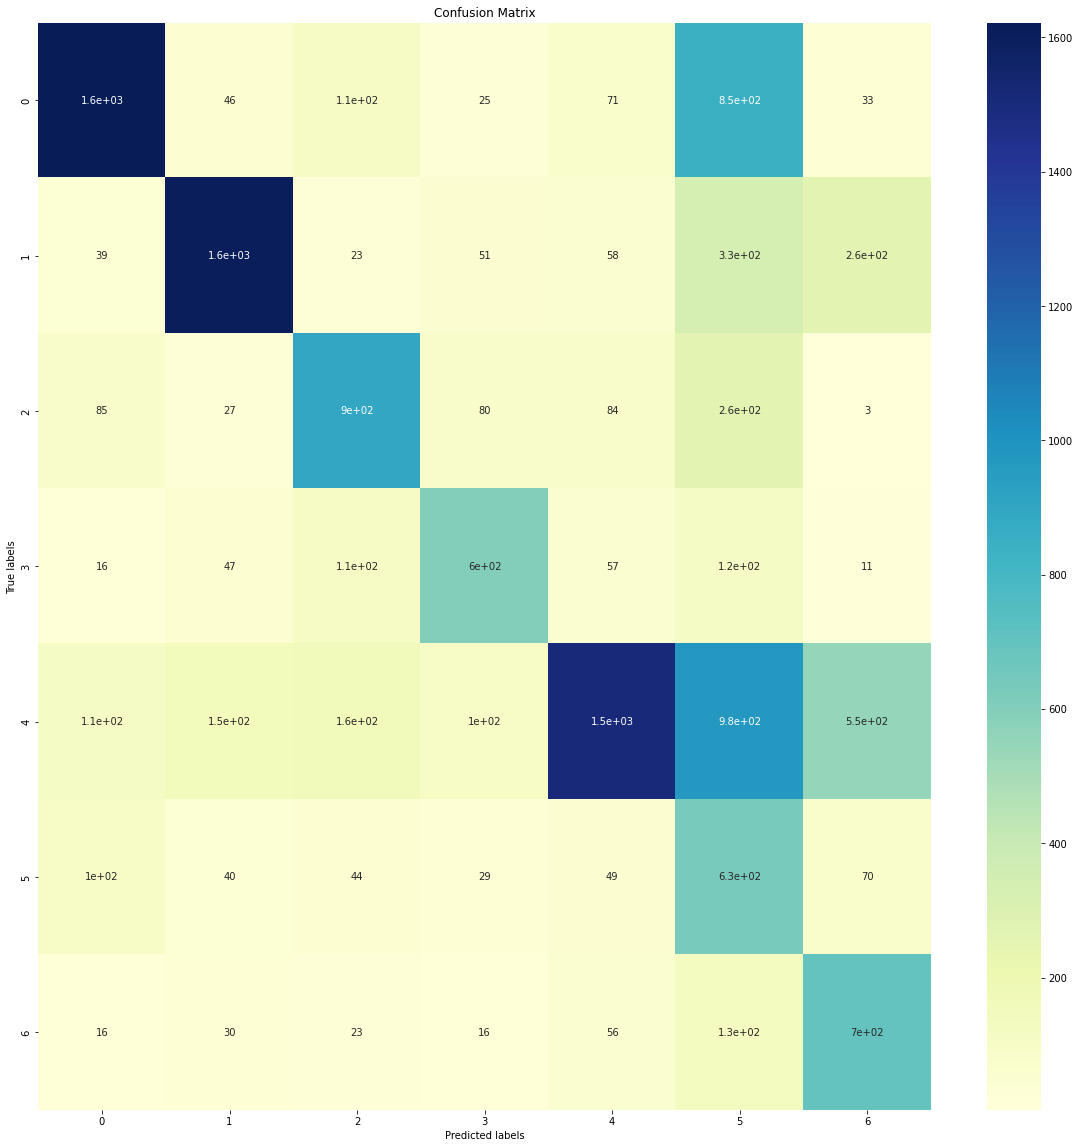

In [53]:
import seaborn as sns
f1, ax1 = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(c_m, annot = True, cmap = "YlGnBu")
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix')

In [60]:
c_r = classification_report(y_test, pred, output_dict = True)

Text(0.5, 1.0, 'Classification report')

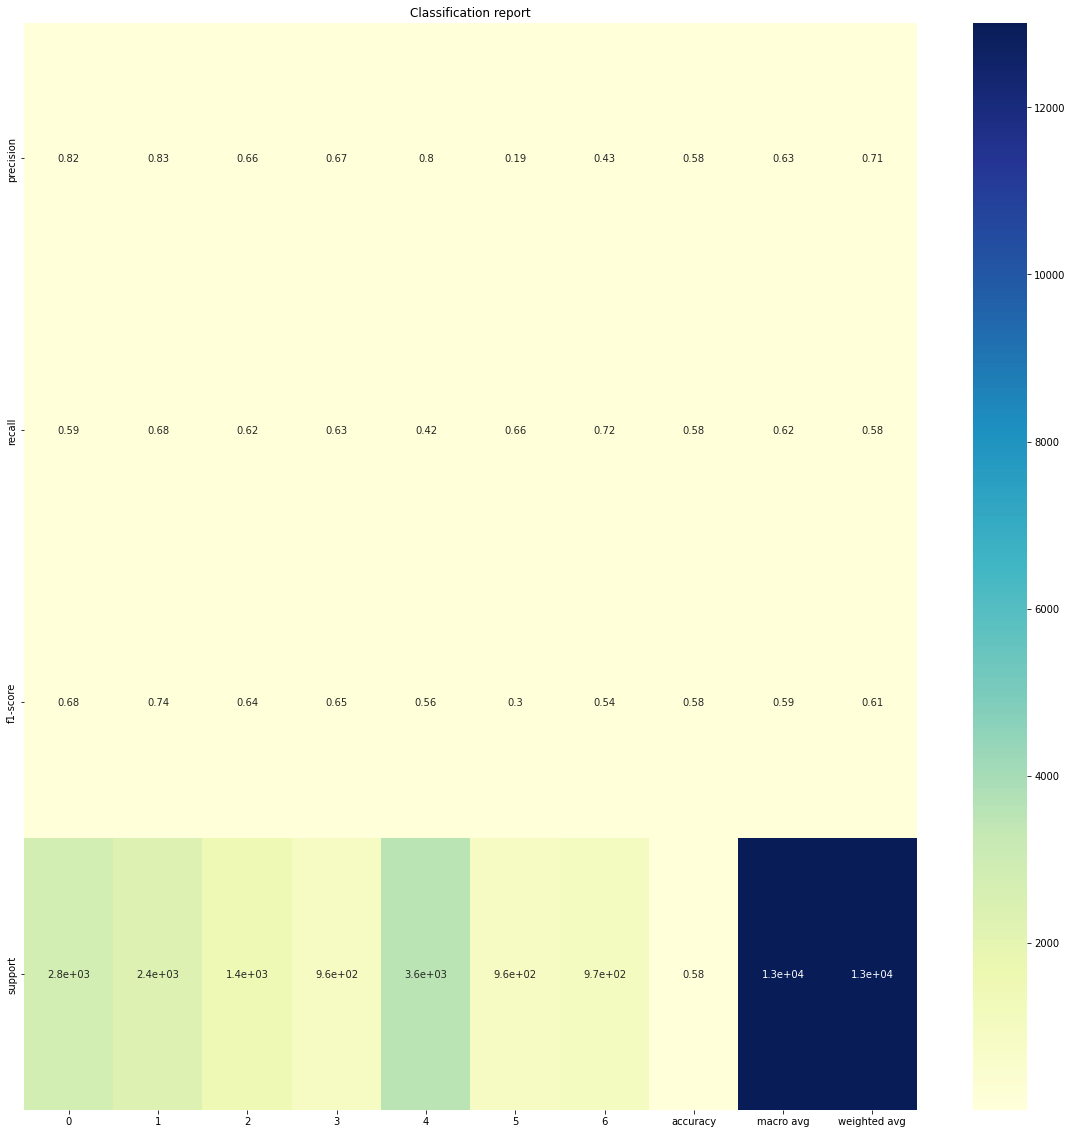

In [64]:
cr = pd.DataFrame(c_r)
f2, ax2 = plt.subplots(1,1, figsize=(20,20))
ax2 = sns.heatmap(cr, annot = True, cmap = "YlGnBu")
ax2.set_title('Classification report')